In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00


In [2]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 12.5 MB/s eta 0:00:00


MoleculeNet: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.MoleculeNet.html

Research Paper: https://arxiv.org/abs/1703.00564


In [19]:
'''Importing the required libraries'''
import torch
import torch.nn.functional as F
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import networkx as nx
import torch.nn as nn

In [4]:
'''Loading the dataset'''
dataset = MoleculeNet(root='path/to/dataset', name='ESOL')
for data in dataset:
    data.x = data.x.float()
    if data.edge_attr is not None:
        data.edge_attr = data.edge_attr.float()

Processing...
Done!


In [6]:
# Display dataset information
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: ESOL(1128)
Number of graphs: 1128
Number of features: 9
Number of classes: 734


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


In [7]:
#Loading the first graph
data = dataset[0]


# Display graph information
print(f'\nGraph Information:')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Graph Information:
Number of nodes: 32
Number of edges: 68
Average node degree: 2.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [26]:
#Whole dataset
total_nodes = 0
total_edges = 0
isolated_nodes_count = 0
self_loops_count = 0
undirected_count = 0

# Iterate over each graph in the dataset
for data in dataset:
    total_nodes += data.num_nodes
    total_edges += data.num_edges
    if data.has_isolated_nodes():
        isolated_nodes_count += 1
    if data.has_self_loops():
        self_loops_count += 1
    if data.is_undirected():
        undirected_count += 1

# Calculate average node degree across all graphs
average_node_degree = total_edges / total_nodes if total_nodes > 0 else float('nan')

# Display aggregate statistics for the whole dataset
print(f'\nDataset Information:')
print(f'Total number of graphs: {len(dataset)}')
print(f'Total number of nodes: {total_nodes}')
print(f'Total number of edges: {total_edges}')
print(f'Average node degree: {average_node_degree:.2f}')
print(f'Graphs with isolated nodes: {isolated_nodes_count}')
print(f'Graphs with self-loops: {self_loops_count}')
print(f'Undirected graphs: {undirected_count}')


Dataset Information:
Total number of graphs: 1128
Total number of nodes: 14991
Total number of edges: 30856
Average node degree: 2.06
Graphs with isolated nodes: 1
Graphs with self-loops: 0
Undirected graphs: 1128


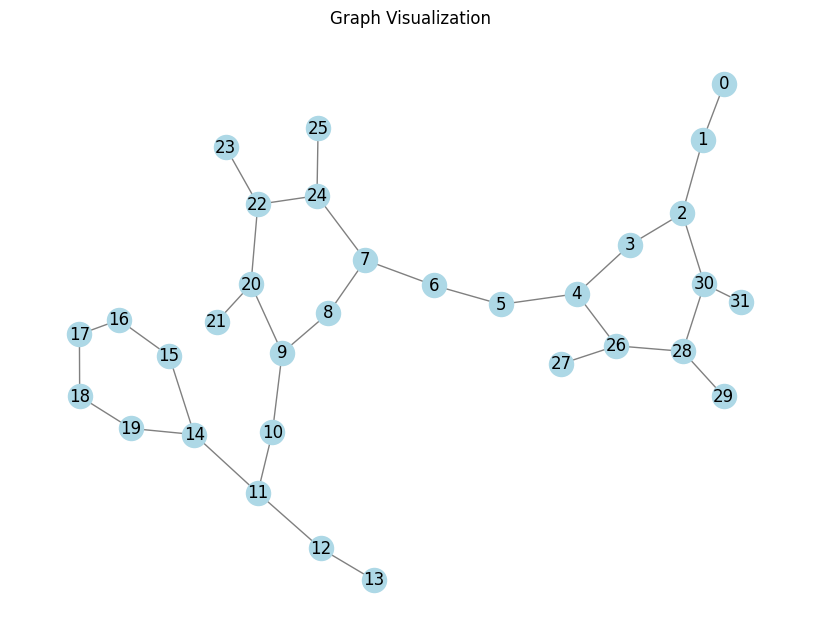

In [8]:
# Visualization using NetworkX and Matplotlib
def visualize_graph(data):
    G = nx.Graph()
    edge_list = data.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()

visualize_graph(data)

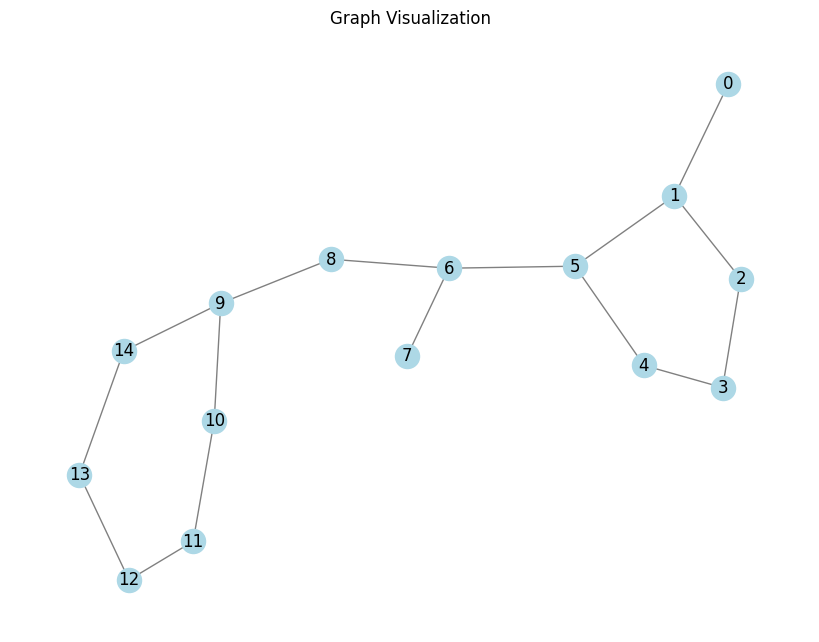

In [27]:
#Visualizing another graph
data1 = dataset[1]
def visualize_graph(data):
    G = nx.Graph()
    edge_list = data.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()

visualize_graph(data1)

In [9]:
# Display node and edge features
print(f'\nNode feature matrix (first 5 nodes):\n{data.x[:5]}')
print(f'Edge index:\n{data.edge_index}')
if data.edge_attr is not None:
    print(f'Edge feature matrix (first 5 edges):\n{data.edge_attr[:5]}')


Node feature matrix (first 5 nodes):
tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1]])
Edge index:
tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 13, 14, 14, 14, 15, 15,
         16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 22, 22, 22, 23, 24, 24,
         24, 25, 26, 26, 26, 27, 28, 28, 28, 29, 30, 30, 30, 31],
        [ 1,  0,  2,  1,  3, 30,  2,  4,  3,  5, 26,  4,  6,  5,  7,  6,  8, 24,
          7,  9,  8, 10, 20,  9, 11, 10, 12, 14, 11, 13, 12, 11, 15, 19, 14, 16,
         15, 17, 16, 18, 17, 19, 14, 18,  9, 21, 22, 20, 20, 23, 24, 22,  7, 22,
         25, 24,  4, 27, 28, 26, 26, 29, 30, 28,  2, 28, 31, 30]])
Edge feature matrix (first 5 edges):
tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])


In [10]:
# Check target feature (solubility)
if hasattr(data, 'y'):
    print("Target (solubility):", data.y)
else:
    print("No target feature found.")

Target (solubility): tensor([[-0.7700]])


In [23]:
for batch in loader:
    print("Target values (first 5):", batch.y[:5])
    break  # Only check the first batch for demonstration

Target values (first 5): tensor([[-2.4000],
        [-4.1200],
        [-4.4700],
        [-0.9600],
        [-3.9280]])


In [20]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = torch.nn.Linear(16, 1)  # Output one value per graph

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Message passing and feature aggregation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        # Pooling to get graph-level representation
        x = global_mean_pool(x, batch)  # Aggregate node features

        return self.fc(x).view(-1)  # Output one prediction per graph

# Instantiate the model and print it
model = GCN()
print('\nModel:\n', model)


Model:
 GCN(
  (conv1): GCNConv(9, 16)
  (conv2): GCNConv(16, 16)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [24]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.MSELoss()  # Use MSE for regression tasks

# Example of using DataLoader to create batches
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(100):  # Number of epochs
    model.train()
    total_loss = 0

    for batch in loader:
        # Ensure batch node features are float type
        if batch.x.dtype != torch.float32:
            batch.x = batch.x.float()
        if batch.edge_attr is not None and batch.edge_attr.dtype != torch.float32:
            batch.edge_attr = batch.edge_attr.float()

        optimizer.zero_grad()  # Zero gradients from previous iteration

        out = model(batch)  # Forward pass

        # Assuming batch.y contains the true labels for regression tasks
        loss = criterion(out, batch.y.float())  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        rmse = (total_loss / len(loader)) ** 0.5  # Calculate RMSE for reporting purposes
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(loader):.4f}, RMSE: {rmse:.4f}')


Epoch 1, Loss: 4.4508, RMSE: 2.1097
Epoch 2, Loss: 4.3630, RMSE: 2.0888
Epoch 3, Loss: 4.3665, RMSE: 2.0896
Epoch 4, Loss: 4.4036, RMSE: 2.0985
Epoch 5, Loss: 4.4284, RMSE: 2.1044
Epoch 6, Loss: 4.3545, RMSE: 2.0867
Epoch 7, Loss: 4.4967, RMSE: 2.1205
Epoch 8, Loss: 4.4300, RMSE: 2.1047
Epoch 9, Loss: 4.4281, RMSE: 2.1043
Epoch 10, Loss: 4.3620, RMSE: 2.0885
Epoch 11, Loss: 4.3375, RMSE: 2.0827
Epoch 12, Loss: 4.3635, RMSE: 2.0889
Epoch 13, Loss: 4.4851, RMSE: 2.1178
Epoch 14, Loss: 4.5181, RMSE: 2.1256
Epoch 15, Loss: 4.4411, RMSE: 2.1074
Epoch 16, Loss: 4.4091, RMSE: 2.0998
Epoch 17, Loss: 4.4329, RMSE: 2.1054
Epoch 18, Loss: 4.5566, RMSE: 2.1346
Epoch 19, Loss: 4.4433, RMSE: 2.1079
Epoch 20, Loss: 4.4765, RMSE: 2.1158
Epoch 21, Loss: 4.4470, RMSE: 2.1088
Epoch 22, Loss: 4.4615, RMSE: 2.1122
Epoch 23, Loss: 4.4064, RMSE: 2.0991
Epoch 24, Loss: 4.5205, RMSE: 2.1262
Epoch 25, Loss: 4.3801, RMSE: 2.0929
Epoch 26, Loss: 4.3694, RMSE: 2.0903
Epoch 27, Loss: 4.3795, RMSE: 2.0927
Epoch 28, 